## Evaluation

In [1]:
import os
os.chdir('..')
print(os.getcwd())

/home/saurabh.nair/giant_nerfs/pytorch-superpoint-new


In [2]:
import numpy as np

import matplotlib.pyplot as plt


%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# file = 'logs/superpoint_coco2_3_hpatches-a_cp/predictions/115.npz'
# file = 'logs/superpoint_coco2_3_hpatches-a2/predictions/115.npz'
file = 'logs/superpoint_coco2_3_hpatches-test/15.npz'
# file = 'logs/superpoint_coco20_5_50k_hpatches/predictions/115.npz'
# 565
data = np.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/superpoint_coco2_3_hpatches-test/15.npz'

In [150]:
list(data)

['prob',
 'warped_prob',
 'desc',
 'warped_desc',
 'homography',
 'image',
 'warped_image']

### matching score - Get the points in shared viewpoint region

In [151]:
image = data['image']
warped_image = data['warped_image']
real_H = data['homography']
keypoints = data['prob'][:,[1, 0]] # (x, y) --> (y, x) 
warped_keypoints = data['warped_prob'][:,[1, 0]] # (x, y) --> (y, x) 

In [152]:
import torch
def getLabels(points_path, img_shape):
    pnts = np.load(points_path)['pts']
    pnts = pnts.astype(int)
    labels = np.zeros((img_shape[0], img_shape[1]))
    labels[pnts[:, 1], pnts[:, 0]] = 1
    labels_2D = torch.tensor(labels[np.newaxis,:,:], dtype=torch.float32)
    return labels_2D, pnts

def pnts2img(pnts, img_shape):
    pnts = pnts.astype(int)
    labels = np.zeros((img_shape[0], img_shape[1]))
    labels[pnts[:, 0], pnts[:, 1]] = 1  # pnts (y,x)
    labels_2D = torch.tensor(labels[np.newaxis,:,:], dtype=torch.float32)
    return labels_2D, pnts

def filter_keypoints(points, shape):
    """ Keep only the points whose coordinates are
    inside the dimensions of shape. """
    """
    input: 
        points:
            numpy (N, (x,y))
        shape:
            (y, x)
    return:
        Points:
            numpy (N, (x,y))
    """
    mask = (points[:, 0] >= 0) & (points[:, 0] < shape[1]) &\
           (points[:, 1] >= 0) & (points[:, 1] < shape[0])
    return points[mask, :]

def warpLabels(pnts, homography, H, W):
    """
    input: 
        pnts: numpy
        homography: numpy
    output:
        warped_pnts: numpy
    """
    from utils.utils import warp_points
    from utils.utils import filter_points
    pnts = torch.tensor(pnts).long()
    homography = torch.tensor(homography, dtype=torch.float32)
    warped_pnts = warp_points(torch.stack((pnts[:, 0], pnts[:, 1]), dim=1),
                                   homography) # check the (x, y)
    warped_pnts = filter_points(warped_pnts, torch.tensor([W, H])).round().long()
    return warped_pnts.numpy()

def img_overlap(img_r, img_g, img_gray):  # img_b repeat
    img = np.concatenate((img_gray, img_gray, img_gray), axis=0)
    img[0, :, :] += img_r[0, :, :]
    img[1, :, :] += img_g[0, :, :]
    img[img > 1] = 1
    img[img < 0] = 0
    img = img.transpose([1,2,0])

    return img

def printImgPnts(image, pnts):
    img_shape = image.shape

    print(img_shape)
    labels_2D, pnts = pnts2img(pnts, img_shape)
    labels_2D = labels_2D.squeeze().numpy()
    print("labels ", labels_2D.shape)

    img_r = np.zeros_like(image)
    overlap = img_overlap(img_r[np.newaxis,:,:], 
                          labels_2D[np.newaxis,:,:], image[np.newaxis,:,:])
    print(overlap.shape)
    plt.imshow(overlap)
    plt.show()

In [153]:
print("pnts max: ", keypoints.max(axis=0))

pnts max:  [475. 635.]


direct predictions
(480, 640)
labels  (480, 640)
(480, 640, 3)


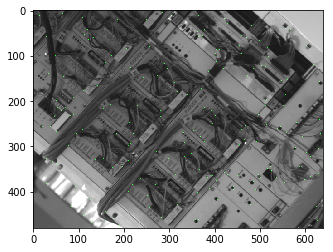

direct predictions - warped
(480, 640)
labels  (480, 640)
(480, 640, 3)


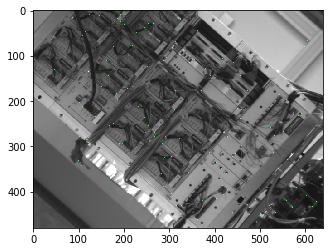

unpared
(480, 640)
labels  (480, 640)
(480, 640, 3)


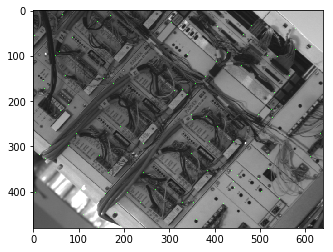

before unwarping:  (706, 2)
after unwarping:  (393, 2)


In [154]:
# unwarp points
from numpy.linalg import inv
H, W = image.shape
unwarped_pnts = warpLabels(warped_keypoints[:, [1, 0]], inv(real_H), H, W)
unwarped_pnts = unwarped_pnts[:,[1,0]]
# unwarped_pnts = filter_keypoints(unwarped_pnts, [240,320])[:,[1,0]]
# project to img
print("direct predictions")
printImgPnts(image, keypoints)

print("direct predictions - warped")
printImgPnts(warped_image, warped_keypoints)

print("unpared")
printImgPnts(image, unwarped_pnts)


print("before unwarping: ", warped_keypoints.shape)
print("after unwarping: ", unwarped_pnts.shape)
# plot

In [155]:
from evaluations.descriptor_evaluation import compute_homography
result = compute_homography(data)
print("correct: ", result['correctness'])

shape:  (240, 320)
desc:  (796, 256)
w desc:  (706, 256)
corner:  [[  0   0   1]
 [  0 239   1]
 [319   0   1]
 [319 239   1]]
real_warped_corners:  [[102.85714722  69.87847137]
 [103.27525332 232.24103088]
 [319.39153002  69.78257233]
 [319.46069416 232.30105423]]
warped_corners:  [[103.73112006  70.06421558]
 [103.80410721 232.22226056]
 [319.12257117  69.5458454 ]
 [319.22508872 232.23800591]]
correct:  True


In [156]:
print("H ground truth: ", data['homography'])
print("H estimated: ", result['homography'])

H ground truth:  [[ 6.7782998e-01  2.4470000e-03  1.0285715e+02]
 [-5.1063002e-04  6.8090999e-01  6.9878471e+01]
 [-3.0094343e-06  6.7547844e-06  1.0000000e+00]]
H estimated:  [[ 6.71924080e-01  2.46525630e-04  1.03731120e+02]
 [-2.34071180e-03  6.78353867e-01  7.00642156e+01]
 [-1.02914403e-05 -5.67028968e-07  1.00000000e+00]]


(480, 640)
warped_img


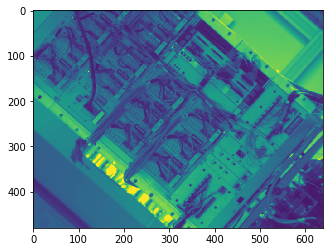

warped_img_Hgt


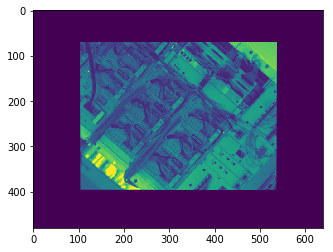

warped_img_Hest


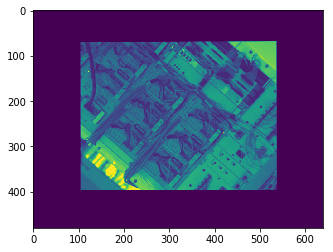

In [158]:
img2 = np.zeros((240,320))
import cv2
warped_img_Hgt = cv2.warpPerspective(image, data['homography'], (image.shape[1], image.shape[0]))
warped_img_Hest = cv2.warpPerspective(image, result['homography'], (image.shape[1], image.shape[0]))
print(warped_img_Hgt.shape)
print("warped_img")
plt.imshow(warped_image)
plt.show()

print("warped_img_Hgt")
plt.imshow(warped_img_Hgt)
plt.show()
print("warped_img_Hest")
plt.imshow(warped_img_Hest)
plt.show()


In [ ]:
printImgPnts(image, unwarped_pnts)
warped_img1 = cv2.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))

reference image
(240, 320)
labels  (240, 320)
(240, 320, 3)


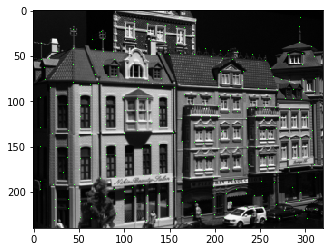

warped image
(240, 320)
labels  (240, 320)
(240, 320, 3)


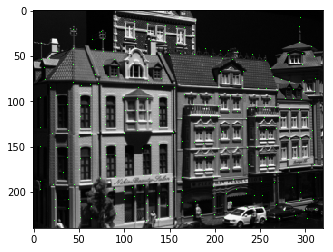

In [8]:
# verify data
print("reference image")
printImgPnts(image, keypoints)

print("warped image")
printImgPnts(warped_image, warped_keypoints)


### NN mAP

In [9]:
file = 'logs/superpoint_pretrained_hpatches/predictions/50.npz'
# file = 'logs/sift_hpatches/predictions/1.npz'
data = np.load(file)

In [10]:
image = data['image']
warped_image = data['warped_image']
real_H = data['homography']
keypoints = data['prob'][:,[1, 0]] # (y, x)
desc = data['desc']
warped_keypoints = data['warped_prob'][:,[1, 0]]

print("keypoints shape: ", keypoints.shape)
print("desc shape: ", desc.shape)


keypoints shape:  (266, 2)
desc shape:  (266, 256)


In [11]:
# compute all matchings from descriptor
from models.model_wrap import PointTracker
%reload_ext autoreload
%autoreload 2

desc = data['desc']
warped_desc = data['warped_desc']

nn_thresh = 2
tracker = PointTracker(max_length=2, nn_thresh=nn_thresh)
# matches = tracker.nn_match_two_way(desc, warped_desc, nn_)
tracker.update(keypoints.T, desc.T)
tracker.update(warped_keypoints.T, warped_desc.T)
matches = tracker.get_matches().T
mscores = tracker.get_mscores().T

# mAP
# matches = data['matches']
print("matches: ", matches.shape)
print("mscores: ", mscores.shape)
print("mscore max: ", mscores.max(axis=0))
print("mscore min: ", mscores.min(axis=0))


matches:  (194, 4)
mscores:  (194, 3)
mscore max:  [265.         272.           1.14739573]
mscore min:  [0.         0.         0.39729849]


In [19]:
def draw_corr(im1, im2, x1, x2, linewidth):
    # im1 = img1_rgb
    # im2 = img2_rgb
    # x1 = x1_sample
    # x2 = x2_sample
    im_shape = im1.shape
    assert im1.shape == im2.shape, 'Shape mismatch between im1 and im2! @draw_corr()'
    x2_copy = x2.copy()
    x2_copy[:, 0] = x2_copy[:, 0] + im_shape[1]
    im12 = np.hstack((im1, im2))

    plt.figure(figsize=(30, 4))
    plt.imshow(im12)
    plt.plot(np.vstack((x1[:, 0], x2_copy[:, 0])), np.vstack((x1[:, 1], x2_copy[:, 1])), marker='o', linewidth=linewidth)
    plt.show()

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
    
def draw_matches_cv(data):
    keypoints1 = [cv2.KeyPoint(p[1], p[0], 1) for p in data['keypoints1']]
    keypoints2 = [cv2.KeyPoint(p[1], p[0], 1) for p in data['keypoints2']]
    inliers = data['inliers'].astype(bool)
    matches = np.array(data['matches'])[inliers].tolist()
    def to3dim(img):
        if img.ndim == 2:
            img = img[:, :, np.newaxis]
        return img
    img1 = to3dim(data['image1'])
    img2 = to3dim(data['image2'])
    img1 = np.concatenate([img1, img1, img1], axis=2)
    img2 = np.concatenate([img2, img2, img2], axis=2)
    return cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches,
                           None, matchColor=(0,255,0), singlePointColor=(0, 0, 255))

In [20]:
import cv2
# count inliers: use opencv homography estimation
# Estimate the homography between the matches using RANSAC
H, inliers = cv2.findHomography(matches[:, [0, 1]],
                                matches[:, [2, 3]],
                                cv2.RANSAC)
inliers = inliers.flatten()
print("Total matchings: ", inliers.shape, ", inliers: ", inliers.sum(), 
      "percentage: ", inliers.sum()/inliers.shape[0] )

Total matchings:  (194,) , inliers:  154 percentage:  0.7938144329896907


Total matches:  194 , inliers:  158 , percentage:  0.8144329896907216
draw inliers


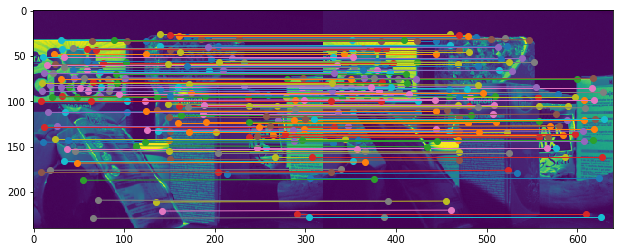

draw outliers


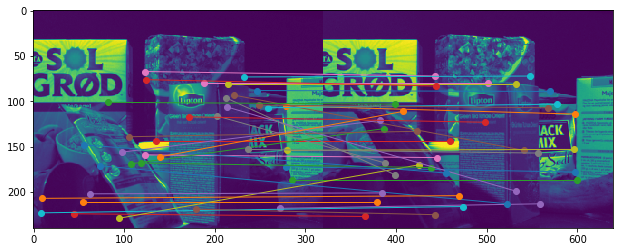

In [37]:
def getInliers(matches, H, epi=3, verbose=False):
    """
    input:
        matches: numpy (n, 4(x1, y1, x2, y2))
        H (ground truth homography): numpy (3, 3)
    """
    from evaluations.detector_evaluation import warp_keypoints
    # warp points 
    warped_points = warp_keypoints(matches[:, :2], H) # make sure the input fits the (x,y)
    
    # compute point distance
    norm = np.linalg.norm(warped_points - matches[:, 2:4],
                            ord=None, axis=1)
    inliers = norm < epi
    if verbose:
        print("Total matches: ", inliers.shape[0], ", inliers: ", inliers.sum(),
                          ", percentage: ", inliers.sum() / inliers.shape[0])
    
    return inliers

inliers = getInliers(matches, real_H, epi=3, verbose=True)
linewidth = 1
print("draw inliers")
mask = inliers == True
draw_corr(image, warped_image, matches[mask][:, [1, 0]], matches[mask][:, [3, 2]], linewidth)
print("draw outliers")
mask = inliers == False
draw_corr(image, warped_image, matches[mask][:, [1, 0]], matches[mask][:, [3, 2]], linewidth)

apply threshold =  0.5
# of matches:  3 , # of inliers:  3 , # of outliers:  0
draw all keep


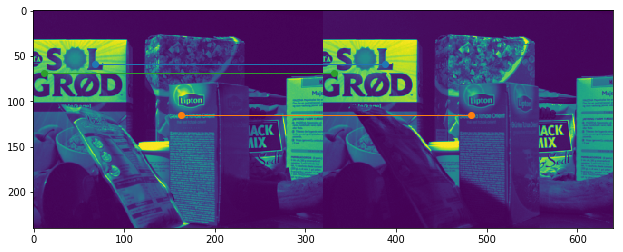

draw mask inliers


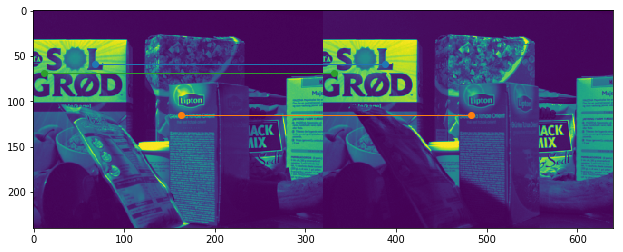

draw mask outliers


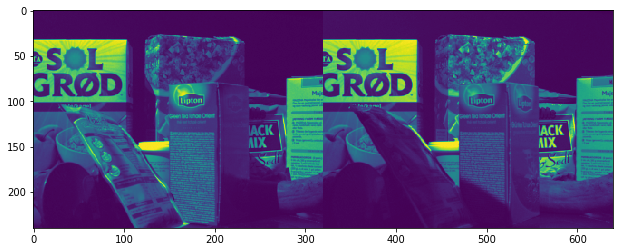

apply threshold =  0.6
# of matches:  22 , # of inliers:  22 , # of outliers:  0
draw all keep


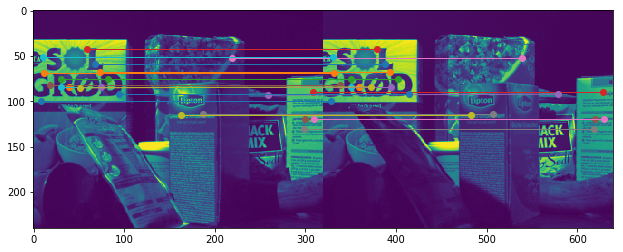

draw mask inliers


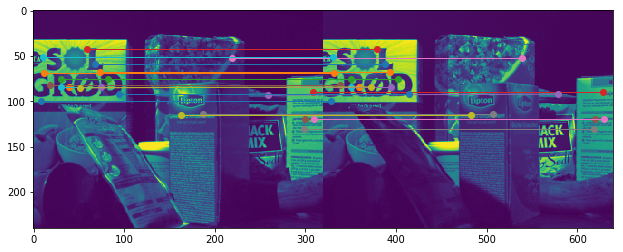

draw mask outliers


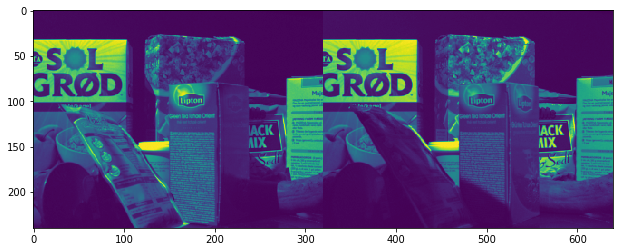

apply threshold =  0.7
# of matches:  48 , # of inliers:  47 , # of outliers:  1
draw all keep


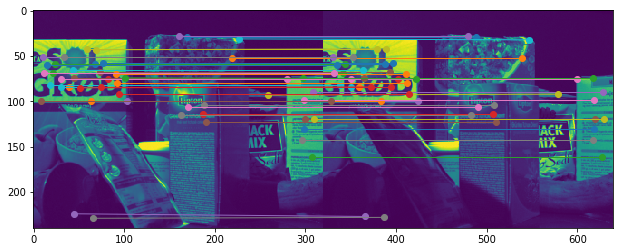

draw mask inliers


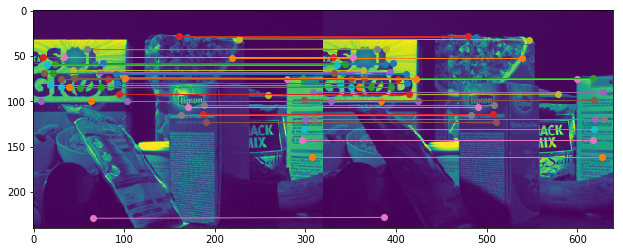

draw mask outliers


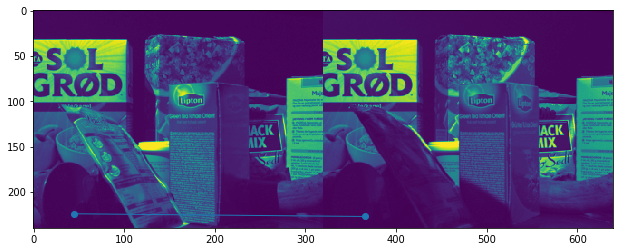

apply threshold =  0.8
# of matches:  95 , # of inliers:  89 , # of outliers:  6
draw all keep


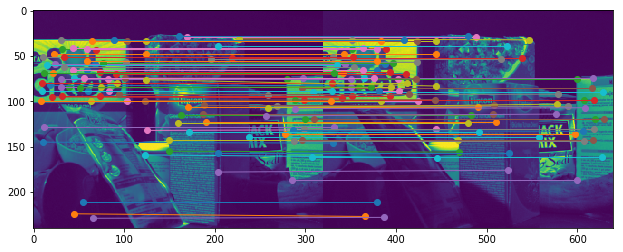

draw mask inliers


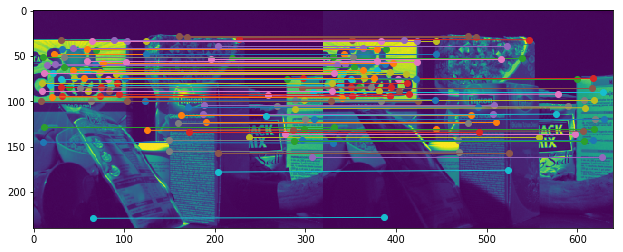

draw mask outliers


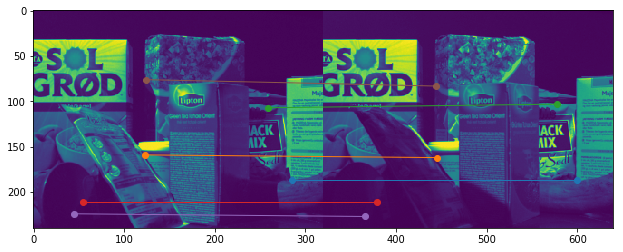

apply threshold =  0.9
# of matches:  149 , # of inliers:  132 , # of outliers:  17
draw all keep


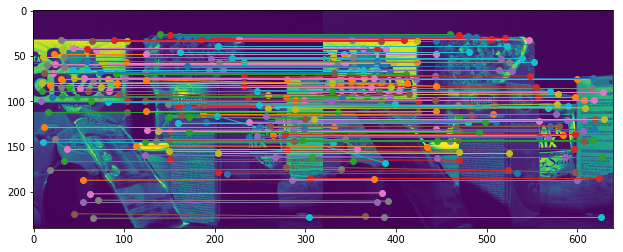

draw mask inliers


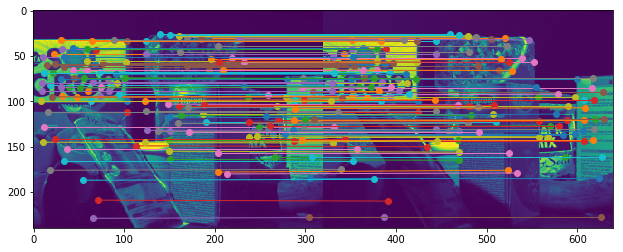

draw mask outliers


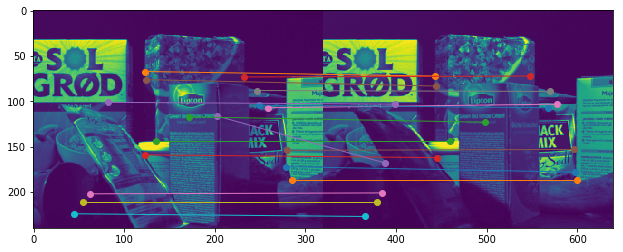

apply threshold =  1.0
# of matches:  170 , # of inliers:  147 , # of outliers:  23
draw all keep


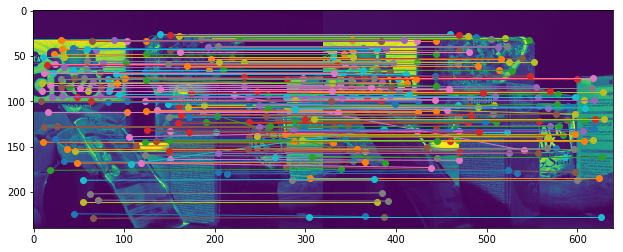

draw mask inliers


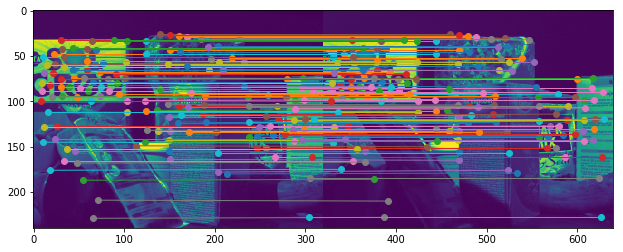

draw mask outliers


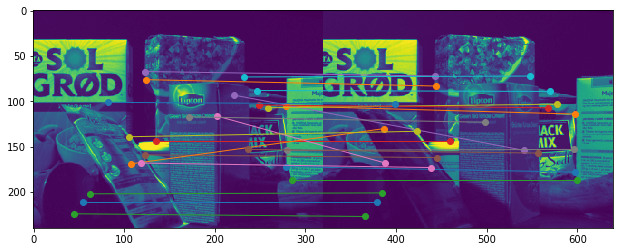

In [41]:
# nn_thresh = 0.7
keep = mscores[:,2] < nn_thresh
threshs = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
linewidth = 1
verbose = True
for thd in threshs:
    print("apply threshold = ", thd)
    keep = mscores[:,2] < thd
    mask_i = keep * (inliers == True)
    mask_o = keep * (inliers == False)
    if verbose:
        print("# of matches: ", keep.sum(), ", # of inliers: ", mask_i.sum(), ", # of outliers: ", mask_o.sum())
    print("draw all keep")
    mask = keep
    draw_corr(image, warped_image, matches[mask][:, [1, 0]], matches[mask][:, [3, 2]], linewidth)
    print("draw mask inliers")
    mask = mask_i
    draw_corr(image, warped_image, matches[mask][:, [1, 0]], matches[mask][:, [3, 2]], linewidth)
    print("draw mask outliers")
    mask = mask_o
    draw_corr(image, warped_image, matches[mask][:, [1, 0]], matches[mask][:, [3, 2]], linewidth)

In [50]:
def inliersThds(mscore, thd, inliers):
    """
    input:
        mscore: numpy(n1,)
        thd: numpy(t,) # different thresholds
        inliers: numpy (n1,)
    output:
        num of inliers under different thd:
            numpy (t,)
    """
    mscore = mscore.reshape(mscore.shape[0], 1)
    thd = thd.reshape(1, thd.shape[0])
    inliers = inliers.reshape(inliers.shape[0], 1)
    matches = mscore < thd # (n1, t)
    n_matches = matches.sum(axis=0)
    n_inliers = (matches)*inliers
    n_inliers = n_inliers.sum(axis=0)
    return n_matches, n_inliers

threshs = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
inliersThds(mscores[:,2], threshs, inliers)

(array([  3,  22,  48,  95, 149, 170]), array([  3,  22,  47,  89, 132, 147]))

In [35]:
matches.shape
inliers.flatten().shape
a = matches[mask][:,[0,1]]
a.shape

(158, 2)

In [16]:
# visualize inliers and outliers
from evaluations.detector_evaluation import warp_keypoints


In [15]:
import sys
print("sys path: ", sys.path)

sys path:  ['', '/home/yoyee/miniconda3/envs/py36_pytorch/lib/python36.zip', '/home/yoyee/miniconda3/envs/py36_pytorch/lib/python3.6', '/home/yoyee/miniconda3/envs/py36_pytorch/lib/python3.6/lib-dynload', '/home/yoyee/.local/lib/python3.6/site-packages', '/home/yoyee/miniconda3/envs/py36_pytorch/lib/python3.6/site-packages', '/home/yoyee/miniconda3/envs/py36_pytorch/lib/python3.6/site-packages/mmdet-0.6rc0+70383d4-py3.6.egg', '/home/yoyee/miniconda3/envs/py36_pytorch/lib/python3.6/site-packages/pycocotools-2.0.0-py3.6-linux-x86_64.egg', '/home/yoyee/miniconda3/envs/py36_pytorch/lib/python3.6/site-packages/terminaltables-3.1.0-py3.6.egg', '/home/yoyee/miniconda3/envs/py36_pytorch/lib/python3.6/site-packages/mmcv-0.2.4-py3.6.egg', '/home/yoyee/miniconda3/envs/py36_pytorch/lib/python3.6/site-packages/addict-2.2.0-py3.6.egg', '/home/yoyee/.local/lib/python3.6/site-packages/IPython/extensions', '/home/yoyee/.ipython']


[[ 1.01840229e+00 -4.61027218e-02  1.07250019e+01]
 [-1.12286784e-02  8.89749156e-01 -3.65693902e+01]
 [ 8.17400297e-05 -5.40527268e-04  1.00000000e+00]]


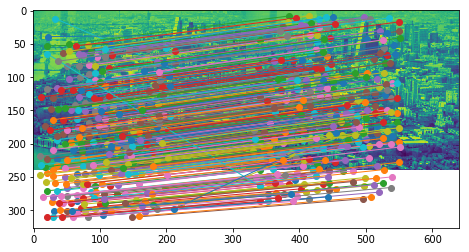

In [34]:


print(H)
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = inliers, # draw only inliers
                   flags = 2)

result = {  'keypoints1': keypoints,
            'keypoints2': warped_keypoints,
            'matches': matches,
            'inliers': inliers,
            'homography': H}
result['image1'] = image
result['image2'] = warped_image

# img = draw_matches_cv(result)
linewidth = 1
draw_corr(image, warped_image, matches[:, [0, 1]], matches[:, [2, 3]], linewidth)


In [35]:
from sklearn.metrics import average_precision_score

m_test = inliers
m_score = mscores[:,2]
thd = 2
average_precision = average_precision_score(m_test, thd -  m_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.95


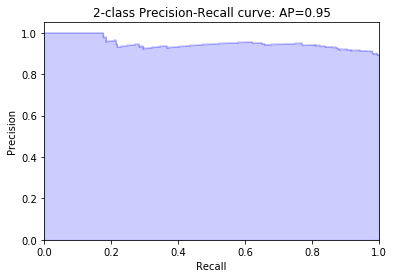

In [36]:
def plotAP(y_test, y_score):

    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    from sklearn.utils.fixes import signature

    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.show()
    
plotAP(m_test, thd - m_score)